In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import scipy as sp
import matplotlib.pyplot as plt

np.random.seed(1234)
# read data
df = pd.read_csv('retail_price.csv')
index = ['product_category_name', 'product_id']
column_min = ['unit_price', 'product_score', 'freight_price', 'product_weight_g', 'comp_1', 'ps1', 'comp_2', 'ps2', 'comp_3', 'ps3']
# column_max = []
column_sum = ['customers']

table_min = pd.pivot_table(df, values=column_min, index=index,  aggfunc=np.min)
# table_min = pivot_table(df, values='D', index=index,  aggfunc=np.max)
table_sum = pd.pivot_table(df, values=column_sum, index=index, aggfunc=np.sum)
table = table_min.merge(table_sum, on=index,how='left')
# Selling & Buying & Rating & Probability of buying
product_category = table.index.get_level_values(0).unique().values

selling = {}
for category in product_category:
    selling[category] = (table.loc[category]['unit_price'].values)

# we set the margin as a uniform % 
buying = {}
for category in product_category:
    buying[category] = selling[category] * np.random.uniform(0.6,0.7, size = len(selling[category]))


rating = {}
for category in product_category:
    rating[category] = (table.loc[category]['product_score'].values)
MAX_RATING = 5.

# Customers
n_customers = {}
for category in product_category:
    n_customers[category] = (table.loc[category]['customers'].sum())

weights = {}
for category in product_category:
    weights[category] = (table.loc[category]['product_weight_g'].values)

softmax={}
for category in product_category:
    softmax[category] = (np.exp(-selling[category]*(MAX_RATING - rating[category]) / 100) 
              / np.sum(np.exp(-selling[category]*(MAX_RATING - rating[category])/100)))

SHIPPING_COST = (table['freight_price'] / table['product_weight_g']).groupby('product_category_name').agg('mean').to_dict()
MARKET_CUSTOMERS = {category: n_customers[category] / np.random.uniform(0.4,0.8) for category in product_category}

print("Buying prices ", buying)
print("RRP ", selling)
print("Product ratings ", rating)
print("Weights ", weights)

Buying prices  {'bed_bath_table': array([ 24.29552232,  49.00360491,  54.6563085 ,  29.96037386,
       110.78392988]), 'computers_accessories': array([41.61372347, 48.89365655, 90.44449434, 79.66454029, 53.05125824,
       95.30368088]), 'consoles_games': array([12.9369803 , 13.30009124]), 'cool_stuff': array([57.53073324, 74.48574951, 19.35552875, 87.78511965, 50.93210844]), 'furniture_decor': array([23.70489318, 48.10966192, 22.01052454, 51.95448642]), 'garden_tools': array([54.67235579, 31.78043179, 34.59636911, 59.85575191, 31.92204086,
       47.4532237 , 31.52101225, 32.77481228, 95.48087071, 32.11650539]), 'health_beauty': array([ 57.81145281,  29.09558626, 217.88848156,  74.41414794,
        18.5941884 , 223.07516763,  39.93483054,  40.62644882,
        48.47241397,  12.36238988]), 'perfumery': array([30.23072904, 78.03380817]), 'watches_gifts': array([ 87.39938654,  77.17918084,  47.03001119,  68.89504734,
       125.96040207,  67.49593372, 103.50451356,  95.91442866])}
RRP  

Text(0, 0.5, 'Product Category')

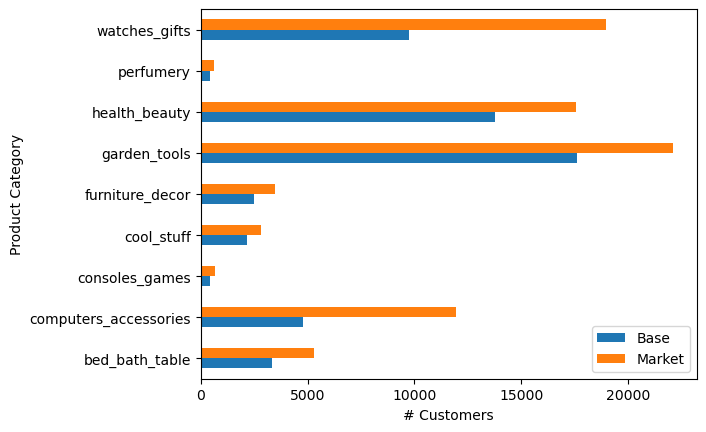

In [2]:
pd.DataFrame([n_customers, MARKET_CUSTOMERS], index = ['Base', 'Market']).T.plot.barh()
plt.xlabel('# Customers')
plt.ylabel('Product Category')

# Given unlimited inventory, when is our business efficient?

In [3]:
def run_model():
    m = gp.Model()

    #BIGNUM = 1e6 # sum(n_customers.values())

    # decision variables
    sold = {}
    discount = {}
    free_shipping = {}
    transport_multiplier = {}
    vars = {
        'sold':sold, 'discount':discount, 'free_shipping':free_shipping,
    }

    # initialising decision variables
    for category in product_category:
        I = range(len(selling[category]))
        sold[category] = m.addVars(I,vtype = GRB.INTEGER)
        discount[category] = m.addVars(I,vtype=GRB.CONTINUOUS, lb=0, ub=1)
        free_shipping[category] = m.addVars(I,  vtype = GRB.BINARY)
        transport_multiplier[category] = m.addVar(vtype = GRB.INTEGER)

    # amount sold and extra customers
    captured_customers = lambda category,i: (
        MARKET_CUSTOMERS[category] * (FREE_SHIPPING_FACTOR * free_shipping[category][i]
                                    + DISCOUNT_FACTOR * discount[category][i])
    )
    amount_sold  = lambda category,i: softmax[category][i]* (n_customers[category] + captured_customers(category,i))
    amount_spent = gp.quicksum( gp.quicksum(sold[category][i] * buying[category][i] for i in range(len(selling[category]))) 
                            for category in product_category)


    # objective function
    m.setObjective(
        gp.quicksum(gp.quicksum(sold[category][i] * selling[category][i] * (1 - discount[category][i]) 
                                - sold[category][i] * buying[category][i]
                                - sold[category][i] * SHIPPING_COST[category] * weights[category][i] * free_shipping[category][i]
                    for i in range(len(selling[category]))) 
                    - BULK_PURCHASE_COST * transport_multiplier[category] for category in product_category),
        GRB.MAXIMIZE
    )

    # Can't store past inventory space
    m.addConstrs( gp.quicksum(sold[category][i] for i in range(len(selling[category]))) <= INVENTORY_SPACE 
                for category in product_category)

    # Can't buy more than the budget
    m.addConstr(amount_spent <= BUDGET)

    for category in product_category:
        # If a product is stocked, is_chosen is set to be 1 [Change to BIGNUM to remove dependencies on n_customers]
        # How much we can sell depends on number of customers [Removed is_chosen]
        m.addConstrs(sold[category][i] <= amount_sold(category, i)
                    for i in range(len(selling[category])))
        m.addConstrs((FREE_SHIPPING_FACTOR * free_shipping[category][i]
                                    + DISCOUNT_FACTOR * discount[category][i]) <= 1 for i in range(len(selling[category])))
        m.addConstrs(transport_multiplier[category] >= (1 / BULK_WEIGHT) * gp.quicksum(sold[category][i] * weights[category][i]
                                                                    for i in range(len(selling[category])))
                                                                    for category in product_category)

    m.params.NonConvex = 2
    m.optimize()
    data = {}
    for category in product_category:
        data[category] = {}
        for v in vars:
            data[category][v] = [a.X for a in vars[v][category].values()]
        data[category]['transport_units'] = transport_multiplier[category].X
        data[category]['captured_customers'] = [captured_customers(category, i).getValue() for i in range(len(selling[category]))]
        data[category]['total_sold'] = [amount_sold(category,i).getValue() for i in range(len(selling[category]))]

    
    objective = data['objective'] = m.getObjective().getValue()
    data['amount_spent'] = amount_spent.getValue()

    return m,objective,data


In [4]:
budgets = np.logspace(2, 8, num=100)
INVENTORY_SPACE = 1e10
FREE_SHIPPING_FACTOR = 0.2
BULK_PURCHASE_COST = 1e2
BULK_WEIGHT = 1e4
DISCOUNT_FACTOR = 2
results = []

for b in budgets:
    BUDGET = b
    m,objective,data = run_model()
    results.append({
        'budget' : b,
        'amount_spent' : data['amount_spent'],
        'model' : m,
        'objective' : objective,
        'data':data
    })

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-26
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i5-12600K, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 195 rows, 165 columns and 913 nonzeros
Model fingerprint: 0xeea9fd1a
Model has 104 quadratic objective terms
Variable types: 52 continuous, 113 integer (52 binary)
Coefficient statistics:
  Matrix range     [1e-02, 4e+03]
  Objective range  [7e+00, 1e+02]
  QObjective range [8e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Found heuristic solution: objective -0.0000000
Presolve removed 185 rows and 129 columns
Presolve time: 0.00s
Presolved: 10 rows, 36 columns, 63 nonzeros
Variable types: 0 continuous, 36 integer (12 binary)

Root relaxation: objective 4.993239e+01, 13 iterations, 0.00 seco

In [8]:
moneys = [{'budget':r['budget'], 'amount_spent':r['amount_spent'], 'profit':r['objective'] }for r in results]
moneys = pd.DataFrame(moneys)
moneys['revenue'] = moneys['profit'] + moneys['amount_spent']
moneys['%profit'] = moneys['profit'] / moneys['amount_spent'] * 100
moneys

,budget,amount_spent,profit,revenue,%profit
0,1.000000e+02,0.000000e+00,0.000000,0.000000e+00,NaN
1,1.149757e+02,0.000000e+00,0.000000,0.000000e+00,NaN
2,1.321941e+02,0.000000e+00,0.000000,0.000000e+00,NaN
3,1.519911e+02,0.000000e+00,0.000000,0.000000e+00,NaN
4,1.747528e+02,1.745128e+02,12.815067,1.873279e+02,7.343338
...,...,...,...,...,...
95,5.722368e+07,2.282069e+06,818743.111855,3.100812e+06,35.877236
96,6.579332e+07,2.282069e+06,818743.111855,3.100812e+06,35.877236
97,7.564633e+07,2.282069e+06,818743.111855,3.100812e+06,35.877236
98,8.697490e+07,2.282069e+06,818743.111855,3.100812e+06,35.877236


Text(0, 0.5, 'Return on Investment')

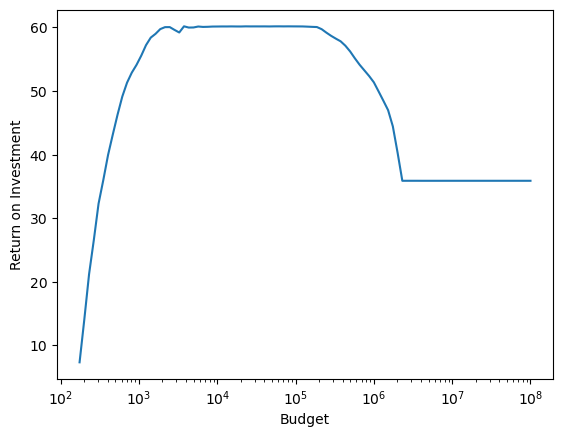

In [9]:
plt.plot(moneys['budget'], moneys['%profit'])
plt.xscale('log')
plt.xlabel('Budget')
plt.ylabel('Return on Investment')

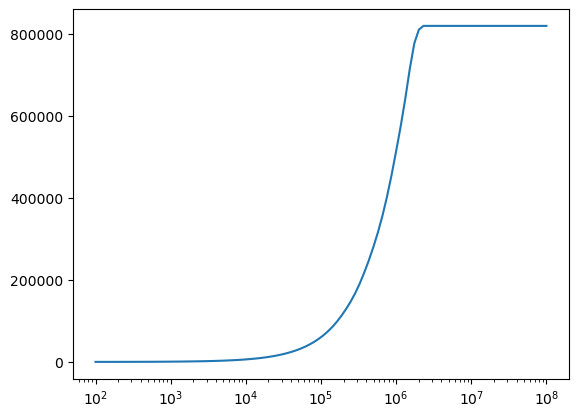

In [10]:
plt.plot(moneys['budget'], moneys['profit'])
plt.xscale('log')

# increasing number of customers?

In [8]:
n_customers

{'bed_bath_table': 3313,
 'computers_accessories': 4807,
 'consoles_games': 439,
 'cool_stuff': 2168,
 'furniture_decor': 2495}

In [9]:
n_customers = {category: n_customers[category]*10 for category in n_customers}
MARKET_CUSTOMERS = {category : MARKET_CUSTOMERS[category]*10 for category in MARKET_CUSTOMERS}

In [17]:
budgets = np.logspace(4, 10, num=50)
INVENTORY_SPACE = 1e8
FREE_SHIPPING_FACTOR = 0.2
BULK_PURCHASE_COST = 1e2
BULK_WEIGHT = 1e4
DISCOUNT_FACTOR = 2
results = []

for b in budgets:
    BUDGET = b
    m,objective,data = run_model()
    results.append({
        'budget' : b,
        'amount_spent' : data['amount_spent'],
        'model' : m,
        'objective' : objective,
        'data':data
    })

moneys = [{'budget':r['budget'], 'amount_spent':r['amount_spent'], 'profit':r['objective'] }for r in results]
moneys = pd.DataFrame(moneys)
moneys['revenue'] = moneys['profit'] + moneys['amount_spent']
moneys['%profit'] = moneys['profit'] / moneys['amount_spent'] * 100
moneys

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i5-12600K, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 75 rows, 71 columns and 289 nonzeros
Model fingerprint: 0xce199a16
Model has 44 quadratic objective terms
Variable types: 22 continuous, 49 integer (22 binary)
Coefficient statistics:
  Matrix range     [1e-02, 4e+04]
  Objective range  [7e+00, 1e+02]
  QObjective range [8e+00, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+08]
Found heuristic solution: objective -0.0000000
Presolve removed 69 rows and 46 columns
Presolve time: 0.00s
Presolved: 6 rows, 25 columns, 45 nonzeros
Variable types: 0 continuous, 25 integer (0 binary)

Root relaxation: objective 5.564294e+03, 5 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Exp

,budget,amount_spent,profit,revenue,%profit
0,1.000000e+04,9.999590e+03,5.538473e+03,1.553806e+04,55.387004
1,1.325711e+04,1.325549e+04,7.366040e+03,2.062153e+04,55.569713
2,1.757511e+04,1.757417e+04,9.736542e+03,2.731072e+04,55.402565
3,2.329952e+04,2.329876e+04,1.293018e+04,3.622894e+04,55.497284
4,3.088844e+04,3.088584e+04,1.713587e+04,4.802171e+04,55.481303
5,4.094915e+04,4.094682e+04,2.271096e+04,6.365778e+04,55.464537
6,5.428675e+04,5.428445e+04,3.020466e+04,8.448911e+04,55.641452
7,7.196857e+04,7.196782e+04,4.000537e+04,1.119732e+05,55.587854
8,9.540955e+04,9.540805e+04,5.301923e+04,1.484273e+05,55.571021
9,1.264855e+05,1.264800e+05,7.034358e+04,1.968236e+05,55.616359


Text(0, 0.5, 'Return on Investment')

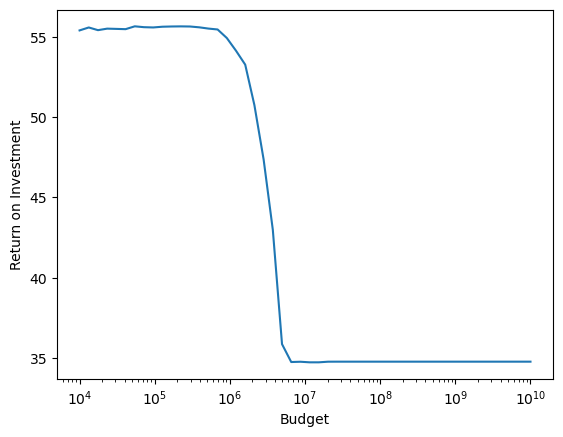

In [18]:
plt.plot(moneys['budget'], moneys['%profit'])
plt.xscale('log')
plt.xlabel('Budget')
plt.ylabel('Return on Investment')

Text(0, 0.5, 'Profit')

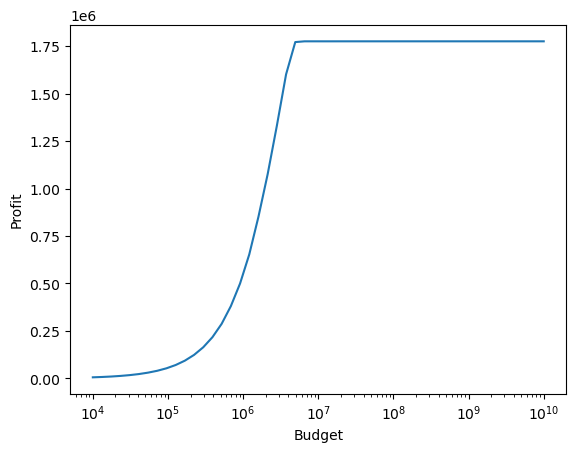

In [19]:
plt.plot(moneys['budget'], moneys['profit'])
plt.xscale('log')
plt.xlabel('Budget')
plt.ylabel('Profit')